In [160]:
import os
import re
import csv
import pandas as pd
import math as m
import numpy as np
import linecache
import string
import matplotlib.pylab as plt
import datetime
import random
import seaborn as sns
from tqdm import tqdm
from sklearn.cluster import KMeans
from wordcloud import WordCloud
import matplotlib

## Part 1: Implementing an hashing function

In [241]:
#directory
os.chdir('C:\\Users\\Skynet\\______ADM______\\HW4')
path = os.getcwd()
path

'C:\\Users\\Skynet\\______ADM______\\HW4'

In [245]:
hash_file = "hash.txt"
line_count = 0

In [246]:
#counting lines
with open(hash_file, "r") as file:
    for line in tqdm(file):
            line_count += 1           
file.close()

print(line_count)

139000000it [01:27, 1580542.91it/s]

139000000


In [247]:
Hashed_zeroes = {}
Hashed_freq = {}

In [265]:
#hashing by inverting the first 5 digits

def new_hash(line):
    
    A = str(line[0:5])
    B = str(line[5::])

    newline = B + A
    
    #new = newline.split("\n")[0] +  newline.split("\n")[1]    

    return newline
    

In [266]:
#Here the dataset is split in 139 module of a million line each because of problems with computer memory
#This process is modular so can be run in multiple istances and then the result dictionary can be merged without problem
#for consecutive zeroes is taken the larger values and for frequencies the values of different obtained dictionary are sum

n = 1000000
N = int(line_count/n)


for chunksize in tqdm(pd.read_csv(path + '/hash.txt', names = ['Hexadecimal'], chunksize = 1000000)):
    BIN1 = []
    
    for position, line in enumerate(chunksize['Hexadecimal']):
        
        length_for_zeroes = len(line)
        
        #process is runned mainly two times
        #One time without hashing and the second time with the intermediation of an hashing function to make some comparison
        #Now code is settled up to create an hashed dictionary
        
        #BIN0 = []
        BIN1 = []
                
        #binary = bin(int(line,16))[2:].zfill(length_for_zeroes)
        #BIN0.append(binary)

        newline = new_hash(line)
        binary = bin(int(newline,16))[2:].zfill(length_for_zeroes)
        BIN1.append(binary)

        for newline in BIN1:
            bucket = int(newline[0:16],2)
            rest = str(newline[16::])

            
            max_zeroes = 0
            max_temp = 0 
            for i in range(len(rest)):

                if rest[i] == "1":
                    max_temp += 1

                    if max_temp > max_zeroes:
                        max_zeroes = max_temp
                else:
                    max_temp = 0
                    
            if bucket not in Hashed_zeroes.keys(): 
                Hashed_zeroes[bucket] = max_zeroes
                Hashed_freq[bucket] = 1
                
            else:    
                Hashed_freq[bucket] += 1
                if max_zeroes > Hashed_zeroes[bucket]:
                    Hashed_zeroes[bucket] = max_zeroes
                    
    file.close()


139it [1:20:59, 34.96s/it]


In [172]:
dicts = Hashed_zeroes, Hashed_freq

with open('Hashed_slip.csv', 'w') as ofile:
    writer = csv.writer(ofile, delimiter=',')
    writer.writerow(['Bucket', 'Hashed_zeroes', 'Hashed_freq'])
    for key in Hashed_zeroes.keys():
        writer.writerow([key] + [d[key] for d in dicts])

In [175]:
#this dataset has been done hashing the lines (BIN1)
Hashed_dataset= pd.read_csv('Hashed_slip.csv', header = 'infer' ) 
Hashed_dataset

Bucket  Hashed_zeroes  Hashed_freq
0       47114             19         4146
1       52427             19         4305
2       45321             16         4305
3       52787             17         4351
4       65526             17         4291
...       ...            ...          ...
32763   53711             16         4143
32764   38336             19         4175
32765   57662             17         4188
32766   64413             23         4224
32767   50641             16         4227

[32768 rows x 3 columns]

In [176]:
#Variance of hashed dataset
print(Hashed_dataset.var()['Hashed_freq'])

5276.352732932523


In [177]:
#this dataset has been done without hashing the lines (BIN0)
no_Hash_dataset= pd.read_csv('No_Hashed.csv', header = 'infer' ) 
no_Hash_dataset

Bucket  Hashed_zeroes  Hashed_freq
0       33856             19         4395
1       65430             20         4309
2       46666             16         4450
3       58433             17         4333
4       46703             18         4398
...       ...            ...          ...
32763   46186             18         4255
32764   42775             16         4270
32765   47495             18         4235
32766   49670             19         4224
32767   59190             18         4264

[32768 rows x 3 columns]

In [178]:
#variance of dataset computed without the hashing function, it's 20% bigger
print(no_Hash_dataset.var()['Hashed_freq'])

6207.629253902875


In [196]:
# HyperLogLog cardinality with harmonic sum
def HLL_cardinality(Hashed_zeroes):
    m = len(Hashed_zeroes)
    k = 0.74902
    harm_sum = 0
    for key in Hashed_zeroes.keys():
        harm_sum += pow(2, -Hashed_zeroes[key])
    print("%.4f" % harm_sum)
        
    cardinality = k * (m**2)/harm_sum
    return cardinality

In [197]:
# LogLog cardinality with geometric sum
def LL_cardinality(Hashed_zeroes):
    m = len(Hashed_zeroes)
    k = 0.74902
    geom_sum_esp = 0
    for key in Hashed_zeroes.keys():
        geom_sum_esp += Hashed_zeroes[key]
    geom_sum_esp = geom_sum_esp/m
    print("%.4f" % geom_sum_esp)
        
    cardinality = k * m * pow(2, geom_sum_esp)
    return cardinality

In [198]:
#cardinality is clearly much improved with HLL
print ("%.2f" % HLL_cardinality(Hashed_zeroes))

0.2553
3150670212.11


In [199]:
print ("%.2f" % LL_cardinality(Hashed_zeroes))

17.8044
5618071942.82


In [207]:
Error = 1.04/m.sqrt(len(Hashed_zeroes))*100
print("Error is " + str("%.2f" % Error) + "%")

Error is 0.57%


This error is obtained with 32768 bucket where each bucket is 8 bits(which can record a maximum of 128 consecutive zeroes, even if the max possible is 112). 

## Part 2 Clustering

In [250]:
food = pd.read_csv('Reviews.csv', header = 'infer') 
food.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

In [143]:
len(food)

568454

In [144]:
food["ProductId"].nunique()

74258

In [251]:
review = food.drop(columns = ['Id', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time' , 'Summary' ])
review.head()

ProductId          UserId  Score  \
0  B001E4KFG0  A3SGXH7AUHU8GW      5   
1  B00813GRG4  A1D87F6ZCVE5NK      1   
2  B000LQOCH0   ABXLMWJIXXAIN      4   
3  B000UA0QIQ  A395BORC6FGVXV      2   
4  B006K2ZZ7K  A1UQRSCLF8GW1T      5   

                                                Text  
0  I have bought several of the Vitality canned d...  
1  Product arrived labeled as Jumbo Salted Peanut...  
2  This is a confection that has been around a fe...  
3  If you are looking for the secret ingredient i...  
4  Great taffy at a great price.  There was a wid...

In [147]:
#merging all reviews related to the same ProductId
unique_prod = review.groupby('ProductId').Text.sum()

In [252]:
unique_prod[:10]

ProductId
0006641040    These days, when a person says, "chicken soup"...
141278509X    This product by Archer Farms is the best drink...
2734888454    My dogs loves this chicken but its a product f...
2841233731    This book is easy to read and the ingredients ...
7310172001    This product is a very health snack for your p...
7310172101    This product is a very health snack for your p...
7800648702    This came in a HUGE tin, much bigger than I ex...
9376674501    Our little dog has a very sensitive stomach.  ...
B00002N8SM    I don't know how this product performs with bi...
B00002NCJC    Why is this $[...] when the same product is av...
Name: Text, dtype: object

In [155]:
#array of all unique product ID
ProductID_ind = np.array(unique_prod.index)

array(['0006641040', '141278509X', '2734888454', ..., 'B009UUS05I',
       'B009WSNWC4', 'B009WVB40S'], dtype=object)

In [40]:
from nltk.corpus import stopwords
from nltk.stem.porter import *
import nltk

stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

In [42]:
numbers =  '1234567890'
alphabet = {'q','w','e','r','t','y','u','i','o','p','a','s','d','f','g','h','j','k','l','z','x','c','v','b','n','m'}

#### Processing of all reviews 

In [44]:
process_dict = {}
for i in tqdm(range(len(unique_prod))): 
              
#for i in range(len(unique_prod)):
              
    text = unique_prod[i]
    Product = unique_prod.index[i]
    
    # replacing punctuation and numbers
    for j in string.punctuation + '—' + numbers:
        text = text.replace(j,' ')
    
    # erasing stop_words (english) and alone letters
    new_text = text.split()
    processed = ""   
    for word in new_text:
        if (word.lower() not in stop_words) and (word.lower() not in alphabet):
            processed += word.lower()  + ' '
    
    # taking just nouns (NN) tokens
    final_processed = ""
    tokens = nltk.word_tokenize(processed)
    tagged = nltk.pos_tag(tokens)
    for word, tag in tagged:
        if (tag == 'NN') :
            if (word not in stop_words) and (word not in alphabet) and (len(word)>2):
                final_processed += word.lower()  + ' '
    
    # there are a few productID which at the end of preprocessing have no text so we are not taking them
    if len(list(set(final_processed.split()))) > 0 :
        process_dict[Product] = final_processed


100%|████████████████████████████████████████████████████████████████████████████| 74258/74258 [44:52<00:00, 27.58it/s]


In [46]:
#preprocessing is not a so fast operation so results are written on csv file to save time

op_file = open("processed_review.csv", "w" , encoding="utf-8")

writer = csv.writer(op_file)
writer.writerow(['ProductId', 'Processed_text'])
for key, value in process_dict.items():
    writer.writerow([key, value])
op_file.close()

In [2]:
processed_dataset= pd.read_csv("processed_review.csv", header = 'infer' ) 
len(processed_dataset)

74174

In [253]:
processed_dataset.head()

ProductId                                     Processed_text
0  0006641040  person soup soul way time person soup rice pow...
1  141278509X  product drink mix packet water bottle sweetner...
2  2734888454  product china buying isnt product china store ...
3  2841233731                  book recipe food son thing snack 
4  7310172001  product health snack pup beef liver puppy pric...

In [5]:
import sklearn.feature_extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
#All rewiews are put in an array

All_text = []
for i in range(len(processed_dataset)):
    All_text.append(processed_dataset.Processed_text[i])


In [8]:
#array of text is vectorized on unique word (words are counted)
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(All_text)

In [10]:
#From count matrix is computed tfidf value for each word and each product
tfidf = sklearn.feature_extraction.text.TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)
Z = tfidf.fit_transform(X)

In [12]:
# the vector of label word for each column in the matrix
feature_names = vectorizer.get_feature_names() 

In [13]:
# each unique word (NN) has a index in a vocabulary
vectorizer.vocabulary_.get('amazon')

1491

In [14]:
import sklearn.decomposition

In [16]:
#Dimensionality reduction trough svd (Singular Value Decomposition)
svd = sklearn.decomposition.TruncatedSVD(n_components=800, algorithm='randomized', n_iter=5, random_state=None, tol=0.0)
Y = svd.fit_transform(Z)


In [18]:
# value 800 components has been chosen to obtain at least a variance ratio sum of at least 0.60
print(svd.explained_variance_ratio_.sum())

0.6182989195127926


In [19]:
len(Y)

74174

In [ ]:
# gives us the absolute value of matrix 
Y = abs(Y)

In [21]:
svd.get_params()

{'algorithm': 'randomized',
 'n_components': 800,
 'n_iter': 5,
 'random_state': None,
 'tol': 0.0}

In [23]:
features = [feature_names[i] for i in svd.components_[0].argsort()[::-1]]
best_features = features[:800]
len(best_features)

800

In [255]:
#best feature are most weighting word in svd truncated matrix
best_features[:20]

['tea',
 'coffee',
 'product',
 'taste',
 'flavor',
 'food',
 'price',
 'time',
 'chocolate',
 'dog',
 'order',
 'sugar',
 'amazon',
 'bag',
 'use',
 'cup',
 'water',
 'box',
 'store',
 'love']

In [56]:
df = pd.DataFrame(Y)

In [256]:
# the matrix of tfidf of words per ProductID
df.head()

0         1         2         3         4         5         6    \
0  0.080308  0.041910  0.051127  0.019596  0.043132  0.012998  0.030938   
1  0.114987  0.055225  0.082189  0.014716  0.040692  0.049411  0.012135   
2  0.088884  0.045996  0.056142  0.029043  0.065888  0.070006  0.048845   
3  0.110385  0.092719  0.136857  0.107978  0.033613  0.121032  0.014800   
4  0.272721  0.197469  0.266438  0.259365  0.058400  0.449732  0.081814   

        7         8         9    ...       790       791       792       793  \
0  0.014390  0.021988  0.041313  ...  0.006447  0.006361  0.003080  0.002783   
1  0.039783  0.090920  0.071627  ...  0.003721  0.001173  0.004313  0.004286   
2  0.158103  0.013517  0.005434  ...  0.012721  0.008096  0.006015  0.002294   
3  0.057693  0.074762  0.001176  ...  0.002528  0.002836  0.005768  0.001217   
4  0.004689  0.010720  0.002738  ...  0.015604  0.016464  0.002037  0.003052   

        794       795       796       797       798       799  
0  0.001445  0.006837  0.008538  0.005755  0.007371  0.005714  
1  0.001095  0.008449  0.005551  0.006881  0.004686  0.001355  
2  0.003965  0.008830  0.008958  0.003189  0.003423  0.001090  
3  0.003172  0.007711  0.010093  0.000313  0.004022  0.005843  
4  0.004285  0.012762  0.006834  0.000358  0.014619  0.000415  

[5 rows x 800 columns]

#### elbow method 

In order to chose the number of clusters we firstly compute the prebuilt kmean

In [133]:
X_clus = []
y_distortions = []
#NB distortions are sum of squared distances from each point to its assign center

for i in tqdm(range(1,17,1)):     
    kmeans = KMeans(n_clusters=i, random_state=0).fit(Y)
    X_clus.append(i)
    y_distortions.append(kmeans.inertia_)
    

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:48<00:00, 84.05s/it]


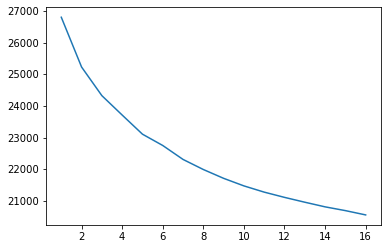

In [134]:
plt.plot(X_clus, y_distortions)

We chose as compromise between precision and cost a number of cluster of 6

once found number of cluster not randomly we run twice the algoritm:

-first time simple k-means 

-second time k-means++


### k-means (from scratch)

In [26]:
#mean of all values in matrix
mean = df.mean().mean()
mean

0.015587161671515302

In [27]:
#standard deviation of each mean columns
std = df.mean().std()
std

0.009514121082401218

In [223]:
#generating casual centroid in the 800th dimensional space

cluster_centers = []

for i in range(6):
    cluster = []
    for j in range(0,800,1):
        #we used the computed before mean and std of values in order to generate centroids which lead to a not too bad solution
        n = round(random.uniform(mean -std, mean + std), 8)
        cluster.append(n)

    cluster_centers.append(cluster)
    
cluster_centers = np.array(cluster_centers)
print(cluster_centers)


[[0.0241954  0.01473128 0.02236155 ... 0.020705   0.01349519 0.02469699]
 [0.01088058 0.0069064  0.01556245 ... 0.02248362 0.00960047 0.00888197]
 [0.01062786 0.00692257 0.01467449 ... 0.01826739 0.01963931 0.01598715]
 [0.02458009 0.01562903 0.01645711 ... 0.01695415 0.02189079 0.0250208 ]
 [0.02251531 0.01354127 0.01443292 ... 0.01729185 0.011535   0.02152823]
 [0.02174101 0.01741108 0.00904446 ... 0.0192091  0.02294977 0.011796  ]]


In [224]:
#compute where each point belongs to which centroid cluster

label = []
sum_dist = np.zeros(6)
for i in tqdm(range(len(df))):    
    dist = []
    
    #computing distance of every point from every centroids
    for j in range(6):
        cc = cluster_centers[j]
        row = np.array(Y[i])
        d = round(np.linalg.norm(row-cc),2)
        dist.append(d)
    
    #point are assigned to the nearest centroids
    min_dist = min(dist)
    idc = dist.index(min_dist)
    sum_dist[idc] += min_dist
    
    label.append(idc)
    

100%|██████████████████████████████████████████████████████████████████████████| 74174/74174 [00:09<00:00, 8238.61it/s]


In [225]:
#sum of distances for every centroids
old_dist = sum_dist
old_dist

array([23329.  ,  7796.46,  1034.21,  5555.82,  8221.75,  2477.  ])

In [227]:
#number of product in each cluster
n_clust = {}
for i in label:
    if i not in n_clust.keys():
        n_clust[i] = 1 
    else:
        n_clust[i] +=1
n_clust  

{2: 1681, 0: 35475, 3: 8502, 1: 11817, 5: 3763, 4: 12936}

In [229]:
#Minimizing distance sum function between centroids and cluster points

lenght = len(df)

#for each cluster
for w in tqdm(range(len(n_clust))):
    
    exit = False
    while exit == False:

        
        improv_dist = 0
        rows = []
        
        #for each one of the unique product
        for j in tqdm(range(lenght)):
            row = []
            # only the labels linked to that specific cluster are considerated
            if label[j] == w:
                
                #for each one of the 800th dimension (referred to words)
                # a number between  the position of centroid and the position of point is generated 
                for k in range(800):
                    a = np.array(Y[j])[k]
                    b = cluster_centers[w][k]
                    n = round(random.uniform(a, b), 8)
                    row.append(n)      
                rows.append(np.array(row))
        #now a set of 800 points is obtained
        
        
        rows = pd.DataFrame(rows)  
        new_center = []
        #here we make the mean of position of every one of the 800 points computed to obtain a better centroid
        for k in range(800):
            new_center.append(rows[k].mean())

        #distances are computed between the new centroid and the rest of its pabel points
        new_center = np.array(new_center)   
        for j in range(lenght):
            if label[j] == w:
                row = np.array(Y[j])
                improv_dist += round(np.linalg.norm(row - new_center), 2)

        #this loop continues until the improvement in sum of distances is inferior to 1 %
        if (improv_dist/sum_dist[w])*100 > 99:
            exit = True
        
        #replace old distance with new ones 
        print("La nuova distanza totale è", improv_dist , )
        if improv_dist < sum_dist[w]:
            cluster_centers[w] = new_center
            sum_dist[w] = improv_dist
            
            
            


  2%|█▋                                                                          | 1633/74174 [00:07<05:57, 202.69it/s]


  4%|███▍                                                                        | 3305/74174 [00:15<05:32, 213.04it/s]


  7%|█████▍                                                                      | 5316/74174 [00:23<04:30, 254.34it/s]


 10%|███████▎                                                                    | 7103/74174 [00:31<05:43, 195.22it/s]


 12%|████████▉                                                                   | 8772/74174 [00:39<05:02, 216.26it/s]


 14%|██████████▎                                                                | 10238/74174 [00:47<06:21, 167.41it/s]


 16%|███████████▋                                                               | 11563/74174 [00:55<06:10, 168.98it/s]


 17%|█████████████                                                              | 12918/74174 [01:03<09:18, 109.73it/s]


 19%|██████████████▍                                                            | 14257/74174 [01:11<05:25, 183.97it/s]


 21%|███████████████▋                                                           | 15491/74174 [01:19<07:54, 123.76it/s]


 23%|████████████████▉                                                          | 16713/74174 [01:28<06:53, 138.99it/s]


 24%|█████████████████▉                                                         | 17725/74174 [01:37<08:14, 114.18it/s]


 25%|██████████████████▉                                                        | 18744/74174 [01:45<07:26, 124.01it/s]


 27%|███████████████████▉                                                       | 19760/74174 [01:53<07:33, 119.90it/s]


 29%|█████████████████████▍                                                     | 21184/74174 [02:02<04:38, 190.08it/s]


 31%|███████████████████████                                                    | 22774/74174 [02:10<05:40, 150.98it/s]


 33%|████████████████████████▉                                                   | 24387/74174 [02:18<11:46, 70.51it/s]


 35%|██████████████████████████▏                                                | 25914/74174 [02:27<03:48, 211.61it/s]


 36%|███████████████████████████▎                                               | 27009/74174 [02:36<07:39, 102.71it/s]


 38%|████████████████████████████▌                                              | 28276/74174 [02:45<04:11, 182.21it/s]


 40%|██████████████████████████████                                             | 29723/74174 [02:52<04:20, 170.75it/s]


 42%|███████████████████████████████▋                                           | 31310/74174 [03:00<02:34, 278.25it/s]


 44%|█████████████████████████████████▎                                         | 32983/74174 [03:08<03:17, 208.09it/s]


 46%|██████████████████████████████████▊                                        | 34432/74174 [03:17<04:15, 155.67it/s]


 49%|████████████████████████████████████▋                                      | 36310/74174 [03:25<02:20, 269.11it/s]


 52%|██████████████████████████████████████▋                                    | 38200/74174 [03:33<03:31, 170.06it/s]


 54%|████████████████████████████████████████▍                                  | 40044/74174 [03:42<03:13, 176.68it/s]


 56%|██████████████████████████████████████████▏                                | 41761/74174 [03:50<02:30, 215.22it/s]


 59%|████████████████████████████████████████████▏                              | 43714/74174 [03:58<02:50, 178.98it/s]


 62%|██████████████████████████████████████████████▎                            | 45744/74174 [04:06<01:38, 288.85it/s]


 64%|████████████████████████████████████████████████▎                          | 47753/74174 [04:13<01:35, 276.26it/s]


 67%|██████████████████████████████████████████████████▎                        | 49739/74174 [04:21<01:38, 247.41it/s]


 70%|████████████████████████████████████████████████████▏                      | 51670/74174 [04:29<01:23, 268.97it/s]


 73%|██████████████████████████████████████████████████████▍                    | 53808/74174 [04:37<01:11, 286.01it/s]


 75%|████████████████████████████████████████████████████████▎                  | 55724/74174 [04:44<01:08, 267.81it/s]


 78%|██████████████████████████████████████████████████████████▎                | 57680/74174 [04:52<01:05, 253.16it/s]


 80%|████████████████████████████████████████████████████████████▏              | 59563/74174 [05:00<01:04, 227.45it/s]


 83%|██████████████████████████████████████████████████████████████             | 61431/74174 [05:08<01:04, 196.60it/s]


 85%|████████████████████████████████████████████████████████████████           | 63351/74174 [05:15<00:36, 296.16it/s]


 88%|██████████████████████████████████████████████████████████████████         | 65336/74174 [05:23<00:29, 297.90it/s]


 90%|███████████████████████████████████████████████████████████████████▊       | 67057/74174 [05:31<00:49, 145.16it/s]


 92%|█████████████████████████████████████████████████████████████████████▎     | 68609/74174 [05:39<00:26, 207.39it/s]


 95%|███████████████████████████████████████████████████████████████████████    | 70334/74174 [05:46<00:20, 191.35it/s]


 97%|████████████████████████████████████████████████████████████████████████▋  | 71826/74174 [05:54<00:10, 222.70it/s]


 99%|██████████████████████████████████████████████████████████████████████████ | 73211/74174 [06:02<00:06, 158.14it/s]


100%|███████████████████████████████████████████████████████████████████████████| 74174/74174 [06:08<00:00, 201.52it/s]

  0%|                                                                              | 35/74174 [00:00<03:35, 344.06it/s]

La nuova distanza totale è 21502.37000000007



  2%|█▎                                                                          | 1278/74174 [00:08<07:35, 160.12it/s]


  3%|██▋                                                                         | 2583/74174 [00:16<06:57, 171.46it/s]


  6%|████▏                                                                       | 4098/74174 [00:24<05:52, 198.52it/s]


  8%|█████▊                                                                      | 5687/74174 [00:32<08:07, 140.51it/s]


  9%|███████▏                                                                    | 6961/74174 [00:40<07:42, 145.48it/s]


 11%|████████▌                                                                   | 8338/74174 [00:48<08:18, 132.09it/s]


 13%|█████████▉                                                                  | 9650/74174 [00:56<06:41, 160.68it/s]


 15%|███████████▍                                                               | 11259/74174 [01:04<07:16, 144.20it/s]


 17%|████████████▊                                                              | 12639/74174 [01:12<05:46, 177.65it/s]


 19%|██████████████                                                             | 13883/74174 [01:20<05:29, 182.95it/s]


 21%|███████████████▍                                                           | 15257/74174 [01:28<05:30, 178.39it/s]


 22%|████████████████▊                                                          | 16636/74174 [01:36<07:01, 136.67it/s]


 24%|██████████████████▏                                                        | 17982/74174 [01:44<06:53, 136.01it/s]


 26%|███████████████████▍                                                       | 19270/74174 [01:52<05:56, 153.96it/s]


 28%|████████████████████▉                                                      | 20715/74174 [02:00<05:28, 162.54it/s]


 30%|██████████████████████▌                                                    | 22281/74174 [02:08<05:07, 168.94it/s]


 32%|████████████████████████                                                   | 23747/74174 [02:16<04:44, 177.37it/s]


 34%|█████████████████████████▌                                                 | 25249/74174 [02:24<05:53, 138.25it/s]


 36%|██████████████████████████▊                                                | 26525/74174 [02:33<05:31, 143.69it/s]


 38%|████████████████████████████▏                                              | 27863/74174 [02:41<05:25, 142.32it/s]


 39%|█████████████████████████████▌                                             | 29240/74174 [02:49<06:12, 120.61it/s]


 41%|██████████████████████████████▊                                            | 30448/74174 [02:56<04:45, 153.22it/s]


 43%|████████████████████████████████▍                                          | 32104/74174 [03:04<03:53, 180.21it/s]


 45%|█████████████████████████████████▉                                         | 33515/74174 [03:12<03:17, 205.50it/s]


 47%|███████████████████████████████████▌                                       | 35224/74174 [03:20<02:44, 236.78it/s]


 50%|█████████████████████████████████████▏                                     | 36733/74174 [03:28<03:16, 191.00it/s]


 52%|██████████████████████████████████████▋                                    | 38218/74174 [03:36<03:50, 156.30it/s]


 54%|████████████████████████████████████████▍                                  | 39964/74174 [03:44<02:58, 191.18it/s]


 56%|█████████████████████████████████████████▊                                 | 41384/74174 [03:52<02:57, 185.07it/s]


 58%|███████████████████████████████████████████▎                               | 42824/74174 [04:00<02:47, 187.04it/s]


 60%|████████████████████████████████████████████▊                              | 44303/74174 [04:08<02:23, 208.48it/s]


 62%|██████████████████████████████████████████████▍                            | 45876/74174 [04:16<02:25, 194.29it/s]


 64%|███████████████████████████████████████████████▉                           | 47355/74174 [04:24<02:15, 198.41it/s]


 66%|█████████████████████████████████████████████████▍                         | 48905/74174 [04:32<02:38, 159.75it/s]


 68%|███████████████████████████████████████████████████                        | 50485/74174 [04:40<01:49, 217.25it/s]


 70%|████████████████████████████████████████████████████▌                      | 52015/74174 [04:48<01:52, 196.89it/s]


 72%|██████████████████████████████████████████████████████▎                    | 53661/74174 [04:56<01:40, 203.54it/s]


 74%|███████████████████████████████████████████████████████▌                   | 55005/74174 [05:04<02:35, 122.90it/s]


 76%|█████████████████████████████████████████████████████████                  | 56486/74174 [05:12<01:29, 196.72it/s]


 78%|██████████████████████████████████████████████████████████▋                | 57988/74174 [05:19<02:10, 124.11it/s]


 80%|███████████████████████████████████████████████████████████▉               | 59287/74174 [05:28<01:43, 144.43it/s]


 82%|█████████████████████████████████████████████████████████████▍             | 60814/74174 [05:36<01:22, 161.47it/s]


 84%|██████████████████████████████████████████████████████████████▉            | 62289/74174 [05:44<01:05, 182.39it/s]


 86%|████████████████████████████████████████████████████████████████▋          | 63923/74174 [05:52<00:54, 188.14it/s]


 88%|██████████████████████████████████████████████████████████████████▏        | 65507/74174 [06:00<00:49, 175.96it/s]


 90%|███████████████████████████████████████████████████████████████████▋       | 66987/74174 [06:07<00:46, 156.18it/s]


 92%|█████████████████████████████████████████████████████████████████████      | 68260/74174 [06:15<00:30, 196.43it/s]


 94%|██████████████████████████████████████████████████████████████████████▍    | 69600/74174 [06:23<00:26, 172.29it/s]


 96%|███████████████████████████████████████████████████████████████████████▊   | 71039/74174 [06:31<00:17, 175.64it/s]


 98%|█████████████████████████████████████████████████████████████████████████▎ | 72550/74174 [06:39<00:09, 169.43it/s]


100%|██████████████████████████████████████████████████████████████████████████▉| 74118/74174 [06:47<00:00, 173.18it/s]


100%|███████████████████████████████████████████████████████████████████████████| 74174/74174 [06:48<00:00, 181.75it/s]

  0%|                                                                              | 21/74174 [00:00<06:07, 201.85it/s]

La nuova distanza totale è 21043.439999999922



  2%|█▎                                                                          | 1318/74174 [00:08<12:02, 100.79it/s]


  3%|██▏                                                                          | 2135/74174 [00:17<26:05, 46.01it/s]


  4%|███                                                                         | 3048/74174 [00:26<08:16, 143.40it/s]


  6%|████▍                                                                       | 4270/74174 [00:34<08:09, 142.83it/s]


  8%|█████▊                                                                      | 5689/74174 [00:43<07:08, 159.79it/s]


  9%|███████▏                                                                    | 6955/74174 [00:51<08:08, 137.57it/s]


 11%|████████▎                                                                   | 8105/74174 [00:59<09:44, 113.10it/s]


 13%|█████████▋                                                                   | 9368/74174 [01:07<11:46, 91.77it/s]


 14%|██████████▎                                                                | 10202/74174 [01:16<07:27, 142.81it/s]


 16%|███████████▊                                                               | 11695/74174 [01:24<05:34, 186.71it/s]


 18%|█████████████▍                                                             | 13267/74174 [01:32<05:20, 189.77it/s]


 20%|██████████████▉                                                            | 14834/74174 [01:40<07:27, 132.66it/s]


 22%|████████████████▍                                                          | 16264/74174 [01:48<04:54, 196.87it/s]


 24%|█████████████████▉                                                         | 17797/74174 [01:56<04:23, 213.71it/s]


 26%|███████████████████▌                                                       | 19338/74174 [02:04<05:18, 172.32it/s]


 28%|█████████████████████▏                                                     | 20995/74174 [02:11<02:43, 325.13it/s]


 30%|██████████████████████▊                                                    | 22594/74174 [02:20<06:03, 142.08it/s]


 33%|████████████████████████▍                                                  | 24198/74174 [02:28<03:44, 223.01it/s]


 35%|██████████████████████████▎                                                | 25986/74174 [02:36<03:50, 209.02it/s]


 37%|███████████████████████████▊                                               | 27507/74174 [02:44<04:11, 185.26it/s]


 39%|█████████████████████████████▏                                             | 28835/74174 [02:52<04:45, 158.94it/s]


 41%|██████████████████████████████▍                                            | 30142/74174 [03:00<04:22, 167.67it/s]


 43%|████████████████████████████████                                           | 31765/74174 [03:08<03:04, 230.36it/s]


 45%|█████████████████████████████████▌                                         | 33240/74174 [03:15<03:40, 185.40it/s]


 47%|███████████████████████████████████▏                                       | 34759/74174 [03:24<03:58, 165.37it/s]


 49%|████████████████████████████████████▌                                      | 36157/74174 [03:32<03:41, 171.90it/s]


 51%|█████████████████████████████████████▉                                     | 37549/74174 [03:40<03:53, 156.94it/s]


 52%|███████████████████████████████████████▏                                   | 38722/74174 [03:48<04:30, 131.13it/s]


 54%|████████████████████████████████████████▊                                  | 40378/74174 [03:57<05:15, 107.29it/s]


 56%|██████████████████████████████████████████                                 | 41607/74174 [04:05<03:36, 150.32it/s]


 58%|███████████████████████████████████████████▌                               | 43096/74174 [04:13<03:06, 166.68it/s]


 60%|█████████████████████████████████████████████                              | 44519/74174 [04:21<03:27, 143.18it/s]


 62%|██████████████████████████████████████████████▌                            | 45994/74174 [04:29<03:39, 128.17it/s]


 64%|████████████████████████████████████████████████                           | 47483/74174 [04:37<02:51, 155.96it/s]


 66%|█████████████████████████████████████████████████▍                         | 48902/74174 [04:46<03:20, 126.25it/s]


 68%|██████████████████████████████████████████████████▊                        | 50225/74174 [04:54<02:23, 167.44it/s]


 70%|████████████████████████████████████████████████████▏                      | 51670/74174 [05:02<01:51, 202.28it/s]


 72%|█████████████████████████████████████████████████████▊                     | 53204/74174 [05:10<01:54, 183.81it/s]


 74%|███████████████████████████████████████████████████████▍                   | 54816/74174 [05:18<02:03, 157.38it/s]


 76%|████████████████████████████████████████████████████████▉                  | 56263/74174 [05:26<01:22, 216.58it/s]


 78%|██████████████████████████████████████████████████████████▍                | 57831/74174 [05:34<02:03, 132.46it/s]


 80%|████████████████████████████████████████████████████████████               | 59356/74174 [05:42<01:27, 168.44it/s]


 82%|█████████████████████████████████████████████████████████████▌             | 60932/74174 [05:50<01:27, 150.87it/s]


 84%|███████████████████████████████████████████████████████████████▏           | 62493/74174 [05:58<00:48, 239.98it/s]


 86%|████████████████████████████████████████████████████████████████▊          | 64157/74174 [06:06<00:53, 186.74it/s]


 89%|██████████████████████████████████████████████████████████████████▍        | 65695/74174 [06:14<00:51, 163.77it/s]


 90%|███████████████████████████████████████████████████████████████████▊       | 67058/74174 [06:22<00:40, 176.07it/s]


 92%|█████████████████████████████████████████████████████████████████████      | 68335/74174 [06:30<00:36, 161.62it/s]


 94%|██████████████████████████████████████████████████████████████████████▌    | 69739/74174 [06:38<00:20, 213.42it/s]


 95%|███████████████████████████████████████████████████████████████████████▌   | 70821/74174 [06:46<00:22, 146.50it/s]


 97%|█████████████████████████████████████████████████████████████████████████  | 72258/74174 [06:54<00:10, 176.76it/s]


 99%|██████████████████████████████████████████████████████████████████████████▌| 73792/74174 [07:02<00:01, 209.26it/s]


  0%|                                                                              | 22/74174 [00:00<05:42, 216.29it/s]

La nuova distanza totale è 20938.44999999992



  6%|████▍                                                                       | 4364/74174 [00:08<02:10, 533.65it/s]


 12%|█████████▏                                                                  | 9019/74174 [00:16<01:45, 615.82it/s]


 18%|█████████████▊                                                             | 13674/74174 [00:25<02:46, 363.11it/s]


 24%|██████████████████▎                                                        | 18091/74174 [00:33<01:44, 535.15it/s]


 30%|██████████████████████▊                                                    | 22560/74174 [00:41<01:37, 530.91it/s]


 35%|██████████████████████████▏                                                | 25955/74174 [00:49<02:23, 336.38it/s]


 41%|██████████████████████████████▋                                            | 30368/74174 [00:58<01:05, 668.05it/s]


 46%|██████████████████████████████████▎                                        | 33936/74174 [01:07<04:10, 160.48it/s]


 52%|██████████████████████████████████████▊                                    | 38330/74174 [01:15<00:56, 630.36it/s]


 59%|████████████████████████████████████████████▍                              | 43907/74174 [01:24<00:37, 810.38it/s]


 65%|████████████████████████████████████████████████▊                          | 48311/74174 [01:32<00:54, 474.00it/s]


 72%|█████████████████████████████████████████████████████▉                     | 53318/74174 [01:40<00:32, 647.39it/s]


 79%|███████████████████████████████████████████████████████████▎               | 58620/74174 [01:47<00:26, 583.55it/s]


 85%|███████████████████████████████████████████████████████████████▉           | 63263/74174 [01:55<00:24, 448.45it/s]


 91%|████████████████████████████████████████████████████████████████████▍      | 67659/74174 [02:03<00:12, 531.71it/s]


 98%|█████████████████████████████████████████████████████████████████████████▍ | 72648/74174 [02:11<00:02, 615.76it/s]


100%|███████████████████████████████████████████████████████████████████████████| 74174/74174 [02:14<00:00, 551.60it/s]

  0%|                                                                              | 33/74174 [00:00<03:48, 324.30it/s]

La nuova distanza totale è 7239.360000000004



  7%|█████▍                                                                      | 5308/74174 [00:07<01:56, 591.66it/s]


 14%|██████████▊                                                                | 10750/74174 [00:16<01:32, 685.48it/s]


 23%|█████████████████                                                          | 16813/74174 [00:24<01:22, 698.73it/s]


 30%|██████████████████████▎                                                    | 22078/74174 [00:32<01:36, 540.35it/s]


 38%|████████████████████████████▌                                              | 28286/74174 [00:40<01:10, 654.30it/s]


 47%|██████████████████████████████████▉                                        | 34523/74174 [00:48<01:03, 623.98it/s]


 55%|█████████████████████████████████████████▍                                 | 40939/74174 [00:56<00:41, 807.68it/s]


 63%|███████████████████████████████████████████████▍                           | 46881/74174 [01:04<00:48, 561.27it/s]


 71%|█████████████████████████████████████████████████████▎                     | 52670/74174 [01:12<00:32, 653.71it/s]


 79%|███████████████████████████████████████████████████████████                | 58412/74174 [01:20<00:23, 668.01it/s]


 86%|████████████████████████████████████████████████████████████████▍          | 63752/74174 [01:27<00:15, 686.22it/s]


 93%|█████████████████████████████████████████████████████████████████████▉     | 69173/74174 [01:35<00:05, 877.17it/s]


100%|███████████████████████████████████████████████████████████████████████████| 74174/74174 [01:43<00:00, 716.49it/s]

  0%|                                                                              | 31/74174 [00:00<04:31, 272.65it/s]

La nuova distanza totale è 7092.569999999995



  6%|████▊                                                                       | 4714/74174 [00:07<01:59, 581.54it/s]


 15%|███████████▏                                                               | 11073/74174 [00:15<01:20, 785.58it/s]


 24%|█████████████████▊                                                         | 17563/74174 [00:23<01:19, 715.68it/s]


 32%|███████████████████████▋                                                   | 23366/74174 [00:31<01:12, 698.25it/s]


 41%|███████████████████████████████                                            | 30694/74174 [00:39<00:56, 773.63it/s]


 49%|████████████████████████████████████▌                                      | 36208/74174 [00:47<00:38, 993.01it/s]


 58%|███████████████████████████████████████████▎                               | 42814/74174 [00:55<00:47, 656.10it/s]


 66%|█████████████████████████████████████████████████▍                         | 48858/74174 [01:03<00:28, 897.68it/s]


 73%|███████████████████████████████████████████████████████                    | 54437/74174 [01:10<00:26, 736.25it/s]


 81%|████████████████████████████████████████████████████████████▉              | 60213/74174 [01:18<00:16, 824.35it/s]


 89%|██████████████████████████████████████████████████████████████████▍        | 65690/74174 [01:26<00:11, 721.05it/s]


 96%|████████████████████████████████████████████████████████████████████████   | 71262/74174 [01:33<00:04, 637.69it/s]


  1%|▌                                                                           | 564/74174 [00:00<00:13, 5333.04it/s]

La nuova distanza totale è 7058.580000000027



 60%|████████████████████████████████████████████▎                             | 44360/74174 [00:07<00:05, 5510.73it/s]


100%|██████████████████████████████████████████████████████████████████████████| 74174/74174 [00:14<00:00, 5239.91it/s]

  1%|▌                                                                           | 559/74174 [00:00<00:13, 5440.54it/s]

La nuova distanza totale è 1001.0299999999991



 62%|█████████████████████████████████████████████▊                            | 45963/74174 [00:07<00:04, 5770.54it/s]


  0%|                                                                              | 34/74174 [00:00<03:43, 330.99it/s]

La nuova distanza totale è 991.7599999999993



 12%|█████████▏                                                                  | 8977/74174 [00:08<01:09, 931.82it/s]


 23%|████████████████▊                                                         | 16905/74174 [00:15<00:55, 1032.96it/s]


 34%|█████████████████████████▎                                                 | 25067/74174 [00:23<00:50, 975.77it/s]


 44%|█████████████████████████████████▎                                         | 32977/74174 [00:31<00:42, 959.74it/s]


 56%|█████████████████████████████████████████▎                                | 41348/74174 [00:39<00:32, 1001.88it/s]


 67%|██████████████████████████████████████████████████▏                        | 49653/74174 [00:47<00:24, 997.93it/s]


 79%|██████████████████████████████████████████████████████████▏               | 58281/74174 [00:55<00:14, 1084.31it/s]


 91%|███████████████████████████████████████████████████████████████████▏      | 67342/74174 [01:03<00:05, 1239.34it/s]


100%|██████████████████████████████████████████████████████████████████████████| 74174/74174 [01:08<00:00, 1075.28it/s]

  0%|                                                                              | 55/74174 [00:00<02:18, 535.40it/s]

La nuova distanza totale è 4996.760000000001



 12%|█████████▏                                                                  | 8963/74174 [00:08<01:09, 934.63it/s]


 23%|████████████████▊                                                         | 16901/74174 [00:15<00:56, 1015.09it/s]


 34%|████████████████████████▊                                                 | 24913/74174 [00:23<00:47, 1033.61it/s]


 44%|████████████████████████████████▌                                         | 32641/74174 [00:31<00:36, 1137.41it/s]


 54%|████████████████████████████████████████▋                                  | 40269/74174 [00:39<00:36, 920.35it/s]


 66%|█████████████████████████████████████████████████▌                         | 49063/74174 [00:47<00:30, 834.03it/s]


 77%|█████████████████████████████████████████████████████████▋                 | 57054/74174 [00:55<00:25, 666.73it/s]


 88%|█████████████████████████████████████████████████████████████████▍        | 65569/74174 [01:02<00:06, 1307.06it/s]


100%|██████████████████████████████████████████████████████████████████████████| 74174/74174 [01:09<00:00, 1061.85it/s]

  0%|                                                                              | 76/74174 [00:00<01:40, 739.66it/s]

La nuova distanza totale è 4855.000000000012



 12%|█████████▏                                                                  | 9012/74174 [00:08<01:12, 894.95it/s]


 23%|█████████████████                                                         | 17065/74174 [00:15<00:51, 1103.75it/s]


 34%|█████████████████████████▎                                                 | 24981/74174 [00:23<00:53, 920.55it/s]


 44%|████████████████████████████████▌                                         | 32620/74174 [00:31<00:35, 1174.06it/s]


 55%|████████████████████████████████████████▊                                 | 40872/74174 [00:39<00:29, 1114.85it/s]


 67%|█████████████████████████████████████████████████▌                        | 49654/74174 [00:47<00:24, 1019.37it/s]


 78%|██████████████████████████████████████████████████████████                | 58153/74174 [00:55<00:12, 1242.05it/s]


 90%|██████████████████████████████████████████████████████████████████▋       | 66833/74174 [01:03<00:06, 1062.25it/s]


  0%|                                                                              | 82/74174 [00:00<01:37, 761.03it/s]

La nuova distanza totale è 4823.199999999982



  7%|█████▎                                                                      | 5204/74174 [00:07<02:11, 524.79it/s]


 15%|███████████                                                                | 10900/74174 [00:15<02:10, 484.21it/s]


 22%|████████████████▎                                                          | 16104/74174 [00:23<01:26, 670.39it/s]


 29%|█████████████████████▍                                                     | 21219/74174 [00:31<01:33, 568.04it/s]


 36%|██████████████████████████▉                                                | 26701/74174 [00:39<01:06, 714.35it/s]


 44%|█████████████████████████████████▏                                         | 32862/74174 [00:47<00:41, 994.55it/s]


 51%|██████████████████████████████████████▌                                    | 38179/74174 [00:55<00:54, 656.80it/s]


 59%|████████████████████████████████████████████▏                              | 43730/74174 [01:03<00:37, 821.20it/s]


 67%|█████████████████████████████████████████████████▉                         | 49386/74174 [01:11<00:37, 653.27it/s]


 74%|███████████████████████████████████████████████████████▍                   | 54838/74174 [01:18<00:30, 638.59it/s]


 81%|████████████████████████████████████████████████████████████▉              | 60320/74174 [01:26<00:20, 665.77it/s]


 88%|██████████████████████████████████████████████████████████████████▎        | 65575/74174 [01:34<00:14, 597.50it/s]


 97%|████████████████████████████████████████████████████████████████████████▋  | 71936/74174 [01:42<00:02, 753.18it/s]


100%|███████████████████████████████████████████████████████████████████████████| 74174/74174 [01:44<00:00, 706.92it/s]

  0%|                                                                              | 79/74174 [00:00<01:34, 783.83it/s]

La nuova distanza totale è 7423.680000000015



  7%|█████▎                                                                      | 5198/74174 [00:07<02:16, 505.29it/s]


 14%|██████████▊                                                                | 10730/74174 [00:15<01:51, 570.94it/s]


 21%|████████████████                                                           | 15942/74174 [00:23<01:31, 636.79it/s]


 29%|█████████████████████▋                                                     | 21406/74174 [00:31<01:36, 548.18it/s]


 36%|███████████████████████████                                                | 26810/74174 [00:39<01:13, 643.67it/s]


 44%|█████████████████████████████████▏                                         | 32793/74174 [00:47<00:45, 911.42it/s]


 51%|██████████████████████████████████████▍                                    | 37997/74174 [00:55<01:00, 597.89it/s]


 59%|███████████████████████████████████████████▉                               | 43436/74174 [01:03<00:43, 701.43it/s]


 66%|█████████████████████████████████████████████████▊                         | 49211/74174 [01:11<00:36, 690.73it/s]


 74%|███████████████████████████████████████████████████████▎                   | 54687/74174 [01:19<00:28, 684.60it/s]


 81%|████████████████████████████████████████████████████████████▉              | 60258/74174 [01:27<00:19, 730.95it/s]


 89%|██████████████████████████████████████████████████████████████████▌        | 65855/74174 [01:34<00:11, 742.89it/s]


 97%|████████████████████████████████████████████████████████████████████████▊  | 72016/74174 [01:42<00:03, 688.36it/s]


100%|███████████████████████████████████████████████████████████████████████████| 74174/74174 [01:45<00:00, 703.71it/s]

  0%|                                                                              | 79/74174 [00:00<01:38, 754.40it/s]

La nuova distanza totale è 7223.909999999996



  7%|█████▏                                                                      | 5046/74174 [00:08<02:20, 491.14it/s]


 14%|██████████▊                                                                | 10644/74174 [00:15<01:39, 637.49it/s]


 21%|███████████████▉                                                           | 15810/74174 [00:23<01:23, 695.18it/s]


 29%|█████████████████████▍                                                     | 21159/74174 [00:31<01:48, 487.31it/s]


 36%|██████████████████████████▉                                                | 26585/74174 [00:39<01:10, 675.23it/s]


 44%|█████████████████████████████████▎                                         | 32985/74174 [00:47<00:47, 865.19it/s]


 52%|██████████████████████████████████████▋                                    | 38254/74174 [00:55<00:51, 691.56it/s]


 59%|████████████████████████████████████████████▎                              | 43826/74174 [01:03<00:35, 856.59it/s]


 66%|█████████████████████████████████████████████████▊                         | 49301/74174 [01:11<00:40, 618.28it/s]


 74%|███████████████████████████████████████████████████████▎                   | 54712/74174 [01:19<00:28, 676.33it/s]


 81%|████████████████████████████████████████████████████████████▉              | 60251/74174 [01:26<00:18, 750.33it/s]


 89%|██████████████████████████████████████████████████████████████████▌        | 65860/74174 [01:34<00:11, 747.88it/s]


 97%|█████████████████████████████████████████████████████████████████████████  | 72220/74174 [01:42<00:02, 729.18it/s]


  1%|▍                                                                           | 379/74174 [00:00<00:20, 3551.70it/s]

La nuova distanza totale è 7181.689999999999



 27%|███████████████████▊                                                      | 19886/74174 [00:07<00:29, 1854.58it/s]


 53%|███████████████████████████████████████▏                                  | 39231/74174 [00:15<00:13, 2608.65it/s]


 78%|██████████████████████████████████████████████████████████                | 58158/74174 [00:23<00:08, 1946.40it/s]


100%|██████████████████████████████████████████████████████████████████████████| 74174/74174 [00:30<00:00, 2411.88it/s]

  1%|▌                                                                           | 545/74174 [00:00<00:14, 5155.37it/s]

La nuova distanza totale è 2311.1799999999967



 27%|███████████████████▋                                                      | 19693/74174 [00:07<00:26, 2047.01it/s]


 53%|██████████████████████████████████████▊                                   | 38960/74174 [00:15<00:14, 2445.58it/s]


 78%|█████████████████████████████████████████████████████████▊                | 58003/74174 [00:23<00:08, 2006.36it/s]


100%|██████████████████████████████████████████████████████████████████████████| 74174/74174 [00:30<00:00, 2441.75it/s]

  1%|▌                                                                           | 525/74174 [00:00<00:14, 5160.80it/s]

La nuova distanza totale è 2266.619999999996



 27%|███████████████████▊                                                      | 19880/74174 [00:07<00:29, 1868.67it/s]


 52%|██████████████████████████████████████▊                                   | 38869/74174 [00:15<00:15, 2284.56it/s]


 79%|██████████████████████████████████████████████████████████▏               | 58379/74174 [00:23<00:08, 1866.94it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [37:50<00:00, 378.46s/it]

La nuova distanza totale è 2257.009999999994


In [230]:
#new sum of distance for every centroid
sum_dist

array([20938.45,  7058.58,   991.76,  4823.2 ,  7181.69,  2257.01])

In [232]:
#new centers obtained
cluster_centers

array([[0.14891708, 0.10043923, 0.08887834, ..., 0.01061865, 0.00935045,
        0.01091014],
       [0.10663633, 0.0540454 , 0.0559124 , ..., 0.01088567, 0.00934788,
        0.00863386],
       [0.0634736 , 0.03335995, 0.03371885, ..., 0.01436084, 0.01532975,
        0.01405813],
       [0.1538527 , 0.10814033, 0.08825721, ..., 0.01081702, 0.01203631,
        0.01186894],
       [0.13380859, 0.07952518, 0.07683535, ..., 0.01009808, 0.0092518 ,
        0.01090863],
       [0.12817186, 0.08094292, 0.04756487, ..., 0.01054218, 0.01117325,
        0.00897502]])

In [283]:
#top k result for each new centroid corresponding each to a word
# these are the word that best summarizes

def topk_word(W,cluster_centers, best_features ):
    word_group = []
    
    for i in range(len(cluster_centers)):
    
        all_values = list(cluster_centers[i])
        temp = cluster_centers[i]
    
        for j in range(6):

            temp = np.array(temp)
            max_value = max(temp)

            idw = all_values.index(max_value)
            word_group.append(best_features[idw])
            temp = list(temp)
            temp.remove(max_value)
    
    return word_group
       

In [299]:
#number of top_k word i want for cluster
W = 5

word_group = topk_word(W,cluster_centers, best_features )
word_group

word_group_shaped = np.array(word_group).reshape((6, 6))
word_group_shaped


array([['tea', 'coffee', 'product', 'taste', 'flavor', 'time'],
       ['tea', 'taste', 'flavor', 'product', 'coffee', 'chocolate'],
       ['tea', 'time', 'flavor', 'taste', 'product', 'coffee'],
       ['tea', 'coffee', 'taste', 'product', 'food', 'cup'],
       ['tea', 'taste', 'coffee', 'flavor', 'product', 'price'],
       ['tea', 'coffee', 'time', 'product', 'taste', 'price']],
      dtype='<U9')

In [308]:
def arrayToString(text):     
    # initialize an empty string 
    string = ""        
    for elem in text:  
        string += elem + " "    
    # return string   
    return string      

(-0.5, 399.5, 199.5, -0.5)

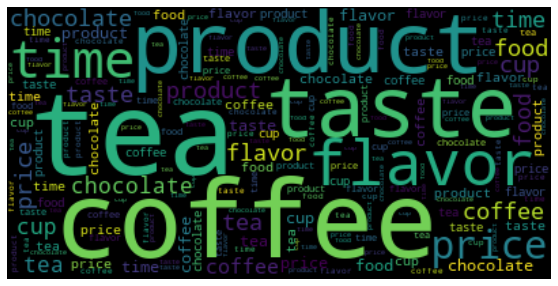

In [300]:
# word visualization

word_string = arrayToString(word_group) 
wc = WordCloud( repeat = True)
img = wc.generate(word_string)

plt.figure(figsize=(11,5))
plt.imshow(img, interpolation='bilinear')
plt.axis("off")

In [347]:
score_cluster = {}
Users_cluster = {}

In [348]:
# connecting to the old dataset to find all unique users and distribution of scores

for i in tqdm(range(len(df))):  
    
    #ProductId_id is the array of unique ProductId
    score = list(review[review.ProductId == ProductID_ind[i]].Score)
    users = list(review[review.ProductId == ProductID_ind[i]].UserId)
    
    if label[i] not in score_cluster.keys():
        score_cluster[label[i]] = score
        Users_cluster[label[i]] = users
     
    else :       
        score_cluster[label[i]].extend(score)
        Users_cluster[label[i]].extend(users)
    

100%|██████████████████████████████████████████████████████████████████████████| 74174/74174 [1:28:52<00:00, 13.91it/s]


In [157]:
#number of unique users for every cluster

number_unique_kscratch = {}
for i in range(6):
    number_unique_kscratch[i] = len(set(Users_cluster[i]))

# 
number_unique_kscratch

{0: 88888, 1: 143396, 2: 30260, 3: 62505, 4: 38530, 5: 14626}

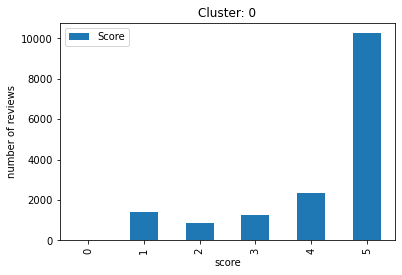

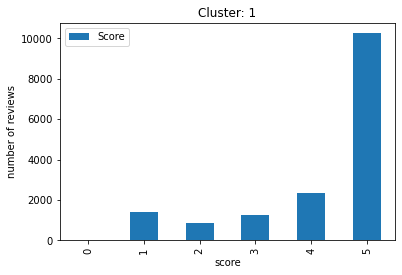

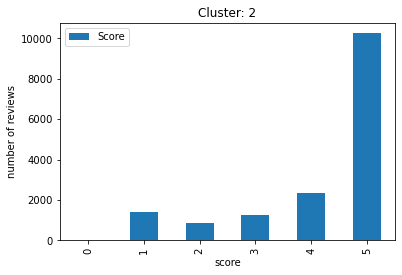

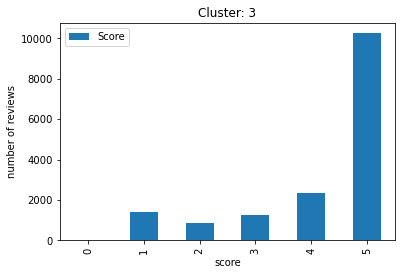

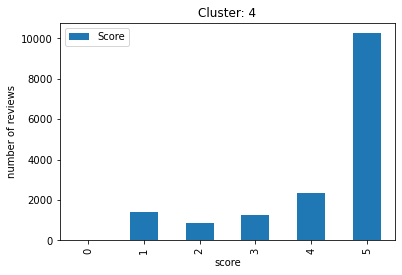

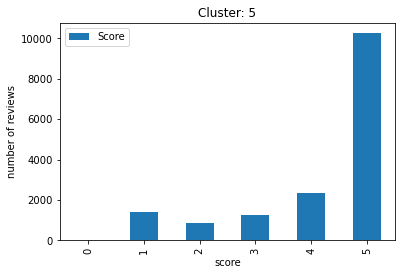

In [351]:
#score distribution for every cluster
for j in range (len(score_cluster)):
    distribution = pd.DataFrame(score_cluster[j], columns= ["Score" ])
    counts_kscratch = []
    
    for i in range(0,6,1):
        counts_kscratch.append(distribution[distribution.Score == i].count())

    counts_kscratch = pd.DataFrame(counts)
    
    counts_kscratch.plot.bar()
    plt.title("Cluster: " + str(j))
    plt.xlabel("score")
    plt.ylabel("number of reviews")
  

### k-means ++

In [237]:
kmeans = KMeans(n_clusters=6, init='k-means++' ,random_state=None).fit(Y)

In [77]:
#number of product in each cluster
n_clust = {}
for i in kmeans.labels_:
    if i not in n_clust.keys():
        n_clust[i] = 1 
    else:
        n_clust[i] +=1
n_clust  

{5: 17700, 3: 16121, 4: 7433, 2: 15332, 0: 4351, 1: 13237}

In [301]:
#number of top_k word i want for cluster
W = 5

word_group = topk_word(W, kmeans.cluster_centers_, best_features )
word_group

word_group_shaped = np.array(word_group).reshape((6, 6))
word_group_shaped

array([['taste', 'tea', 'food', 'product', 'flavor', 'coffee'],
       ['tea', 'coffee', 'product', 'time', 'taste', 'flavor'],
       ['product', 'tea', 'coffee', 'taste', 'texture', 'family'],
       ['tea', 'coffee', 'product', 'taste', 'flavor', 'time'],
       ['coffee', 'tea', 'taste', 'texture', 'order', 'box'],
       ['tea', 'chocolate', 'dog', 'order', 'sugar', 'price']],
      dtype='<U9')

(-0.5, 399.5, 199.5, -0.5)

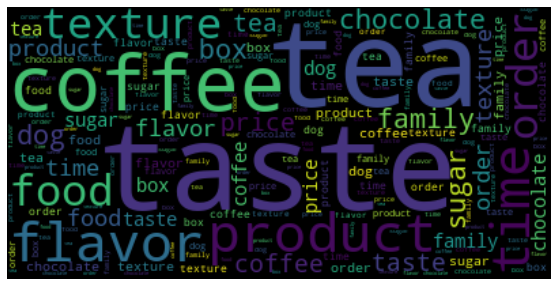

In [302]:
# word visualization
word_string = listToString(word_group) 
wc = WordCloud( repeat = True)
img = wc.generate(word_string)

plt.figure(figsize=(11,5))
plt.imshow(img, interpolation='bilinear')
plt.axis("off")

In [329]:
score_cluster_built = {}
Users_cluster_built = {}

In [360]:
# connecting to the old dataset to find all unique users and distribution of scores

for i in tqdm(range(len(df))):  
    
    #ProductId_id is the array of unique ProductId
    score = list(review[review.ProductId == ProductID_ind[i]].Score)
    users = list(review[review.ProductId == ProductID_ind[i]].UserId)
    
    
    if kmeans.labels_[i] not in score_cluster_built.keys():
        score_cluster_built[kmeans.labels_[i]] = score
        Users_cluster_built[kmeans.labels_[i]] = users
     
    else :       
        score_cluster_built[kmeans.labels_[i]].extend(score)
        Users_cluster_built[kmeans.labels_[i]].extend(users)



100%|██████████████████████████████████████████████████████████████████████████| 74174/74174 [1:24:51<00:00, 14.57it/s]


In [361]:
#numbert of unique users for every cluster
number_unique_kbuilt = {}
for i in range(6):
    number_unique_kbuilt[i] = len(set(Users_cluster_built[i]))

number_unique_kbuilt

{0: 38452, 1: 108766, 2: 24150, 3: 110308, 4: 29849, 5: 70345}

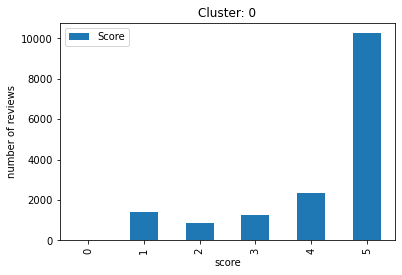

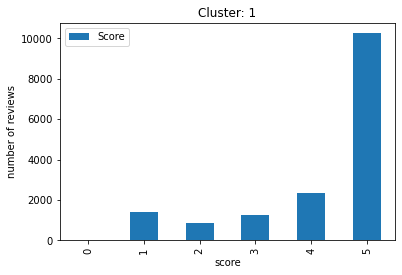

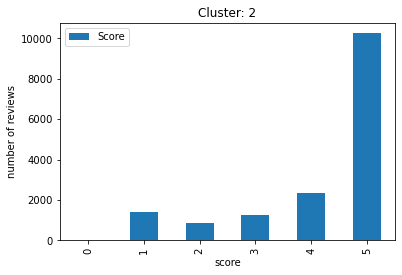

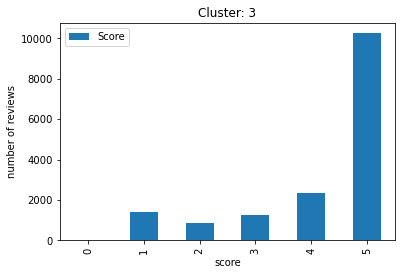

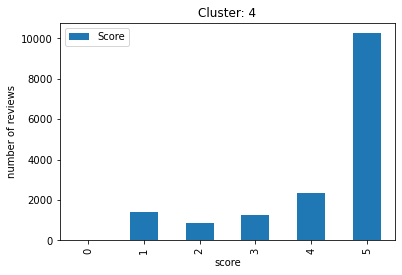

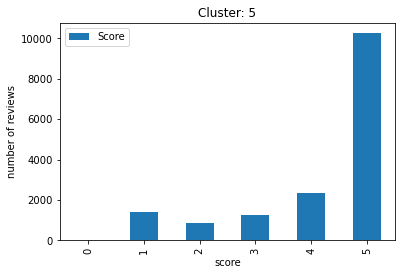

In [363]:
#score distribution for every cluster
for j in range (len(score_cluster_built)):
    
    distribution = pd.DataFrame(score_cluster_built[j], columns= ["Score" ])
    counts_kbuilt = []
    
    for i in range(0,6,1):
        counts_kbuilt.append(distribution[distribution.Score == i].count())

    counts_kbuilt = pd.DataFrame(counts)
    
    counts_kbuilt.plot.bar()
    plt.title("Cluster: " + str(j))
    plt.xlabel("score")
    plt.ylabel("number of reviews")
  

#### Comparison (between kmean by scratch and prebuilt kmean++)

In [307]:
for row1, row2 in zip(kmeans.cluster_centers_, cluster_centers):
    print(np.sum(row1),  np.sum(row2))

12.02024914855292 12.603257989543625
11.555949135036968 13.228190872569181
11.13805778649094 13.08716559518739
14.03839977932443 11.614084625529287
10.76512262003068 11.488887336254635
12.516107294151807 13.613731112115332


From wordcloud visualization we can se how the most showed word (and their respective size that mean their frequency among cluster) are very similar and in many case the same. So there's no much evidence of a difference between the behaviour of the two algorithms.

Also if we try to compare centroids (for example by summing rows) we can see as numbers obtained are really similar.

We expected the prebuilt and optimized kmeans++ to be way faster and in fact there is instead a substantial difference in execution time between the two algorithms.

In [310]:
#number of unique UserId for cluster for handmade algorithm
number_unique_scratch

{0: 88888, 1: 143396, 2: 30260, 3: 62505, 4: 38530, 5: 14626}

In [362]:
#number of unique UserId for cluster for prebuilt algorithm
number_unique_kbuilt 

{0: 38452, 1: 108766, 2: 24150, 3: 110308, 4: 29849, 5: 70345}

## Part 3: Algorithmic question

given:

s = min{A[1],...,A[n]}

b = max{A[1],...,A[n]}

r = b-s

prove that to sort A $\longrightarrow$ O(r + n)

to find min and max :
    
    for range n:           |
        if A[i] < min:     |
            min = A[i]     |    O(n)    
        if A[i] > max:     |
            max = A[i]     |
    
    
    
Now let's write two array:

    sequence = [min, min+1, min+2 ... max-2, max-1, max ]   all int number from min to max |             O(r)
                                                                                           |   because sequence can be at 
    true_false = [ 0,0,0.... 0]  an array of zeroes                                        |    max of r different numbers


Now in the best situation if A contains every consecutive number to sort it is just O(n). If  ordered number are not consecutive instead we can write :

    for i in range(r):                                     |
        if A[i] ==seq[A[i] - min]:                         |     O(r)
            true_false[A[i] - min] = 1                     |
(if the number is in array A put 1 in array true false)
     
    sortedA = [] 
    for i in range(r):                                     |
        if True[i] == 1:                                   |     O(r)
            sortedA.append(i)                              |
(in true_false number are already sorted)       



So time complexity is equal to $ O( n + 3r ) \sim O(n + r )$